In [ ]:
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


import logging

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

#Set random seed
np.random.seed(24)


In [ ]:
#read CSV file containing tweets and labels, using Pandas , to get a dataframe
tweetsData = pd.read_csv('/content/drive/MyDrive/MSc DS_NLP/sentiment.csv', skiprows=[8835, 535881]) #skiping these two rows as they have some bad data
tweetsData.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
tweetsData = tweetsData[tweetsData.sentiment != 'neutral']

In [ ]:

#Dividing the dataset into features and lables
tweets = tweetsData['text']
labels = tweetsData['sentiment']

In [ ]:
tweetsData['sentiment'].replace('positive', 0,inplace=True)
tweetsData['sentiment'].replace('negative',1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0    8582
1    7781
Name: sentiment, dtype: int64


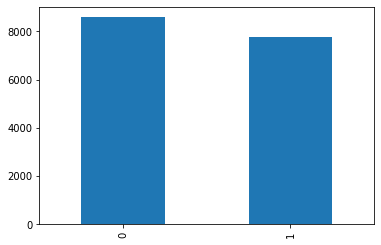

In [ ]:
#check the distribution of lebels

labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [ ]:
#Lower and split the dialog
#and use regular expression to keep only letters we will use nltk Regular expression package
tkr = RegexpTokenizer('[a-zA-Z@]+')



In [ ]:
tweets_split = []

for i, line in enumerate(tweets):
    #print(line)
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_split.append(tweet)

print(tweets_split[1])

['my', 'boss', 'is', 'bullying', 'me']


In [ ]:
'''
Use pretrained Word2Vec model from google but trim the word list to 50,0000 compared to 300,000 in the original
Google pretrained model
'''

w2vModel = word2vec.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MSc DS_NLP/GoogleNews-vectors-negative300.bin', binary=True, limit=50000)

2022-03-15 08:40:26,461 : INFO : loading projection weights from /content/drive/MyDrive/MSc DS_NLP/GoogleNews-vectors-negative300.bin
2022-03-15 08:40:27,440 : INFO : loaded (50000, 300) matrix from /content/drive/MyDrive/MSc DS_NLP/GoogleNews-vectors-negative300.bin


In [ ]:
#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

In [ ]:
#lenght of tweet to consider
maxlentweet = 10
#add paddingape)

#create a embedding layer using Google pre triained word2vec (50000 words)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])

X = pad_sequences(X, maxlen=maxlentweet)
print(X.sh
#create model


(16363, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
lstm_out = 80

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=lstm_out))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           15000000  
                                                                 
 lstm_4 (LSTM)               (None, 80)                121920    
                                                                 
 dense_4 (Dense)             (None, 1)                 81        
                                                                 
Total params: 15,122,001
Trainable params: 15,122,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)


In [ ]:
X_train

array([[  318,   195,    22, ...,    47,    89,    17],
       [   34,    77,     7, ...,    58,   561,   295],
       [    0,     0,     0, ...,    22,  3133,    38],
       ...,
       [16653,    32,    25, ...,   216,   379,   728],
       [   57,    88,  3244, ...,     6,    16,  7892],
       [  109,   937,    12, ...,   131,     7,   107]], dtype=int32)

In [ ]:
Y_train

1069     1
25364    0
27350    1
16283    0
6183     0
        ..
5824     1
14340    1
24305    0
1478     1
21255    1
Name: sentiment, Length: 14726, dtype: int64

In [ ]:
#import tensorflow as tf
#Y_train = tf.keras.utils.to_categorical(Y_train, 2)
#Y_test = tf.keras.utils.to_categorical(Y_test, 2)

In [ ]:
#fit model
batch_size = 32
model.fit(X_train, Y_train, epochs=1, verbose=1, batch_size=batch_size)


461/461 [==============================] - 82s 168ms/step - loss: 0.4716 - accuracy: 0.7651


In [ ]:
#analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

52/52 - 2s - loss: 0.4124 - accuracy: 0.8057 - 2s/epoch - 45ms/step


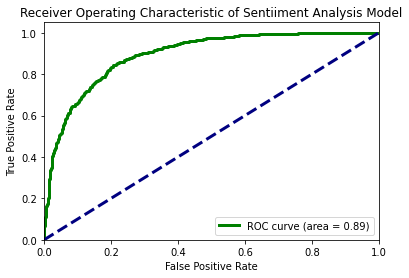

In [ ]:
#ROC AUC curve
rocAuc = roc_auc_score(Y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(Y_test, y_pred)

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Other accuracy metrices
y_pred = (y_pred > 0.5)

#confusion metrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

#F1 Score, Recall and Precision
print(classification_report(Y_test, y_pred, target_names=['Positive', 'Negative']))


[[690 154]
 [164 629]]
              precision    recall  f1-score   support

    Positive       0.81      0.82      0.81       844
    Negative       0.80      0.79      0.80       793

    accuracy                           0.81      1637
   macro avg       0.81      0.81      0.81      1637
weighted avg       0.81      0.81      0.81      1637



In [ ]:
# https://github.com/mjain72/Sentiment-Analysis-using-Word2Vec-and-LSTM/blob/master/SentimentAnalysisTwitter.py